In [26]:
import keras
keras.__version__

'2.4.3'

# 컨브넷의 학습 시각화하기

이 노트북은 [케라스 창시자에게 배우는 딥러닝](https://tensorflow.blog/%EC%BC%80%EB%9D%BC%EC%8A%A4-%EB%94%A5%EB%9F%AC%EB%8B%9D/) 책의 5장 4절의 코드 예제입니다. 책에는 더 많은 내용과 그림이 있습니다. 이 노트북에는 소스 코드에 관련된 설명만 포함합니다.

----

딥러닝 모델을 '블랙 박스' 같다고 자주 이야기합니다. 학습된 표현에서 사람이 이해하기 쉬운 형태를 뽑아내거나 제시하기 어렵기 때문입니다. 일부 딥러닝 모델에서는 이 말이 어느정도 맞지만 컨브넷에서는 전혀 아닙니다. 컨브넷의 표현은 시각적인 개념을 학습한 것이기 때문에 시각화하기 아주 좋습니다. 2013년부터 이런 표현들을 시각화하고 해석하는 다양한 기법들이 개발되었습니다. 여기서 모두를 다룰 수는 없지만 가장 사용이 편하고 유용한 세 가지 기법을 다루겠습니다.

* 컨브넷 중간 층의 출력(중간 층에 있는 활성화)을 시각화하기 : 연속된 컨브넷층이 입력을 어떻게 변형시키는지 이해하고 개별적인 컨브넷 필터의 의미를 파악하는 데 도움이 됩니다.
* 컨브넷 필터를 시각화하기 : 컨브넷의 필터가 찾으려는 시각적인 패턴과 개념이 무엇인지 상세하게 이해하는 데 도움이 됩니다.
* 클래스 활성화에 대한 히트맵을 이미지에 시각화하기 : 이미지의 어느 부분이 주어진 클래스에 속하는 데 기여했는지 이해하고 이미지에서 객체의 위치를 추정하는 데 도움이 됩니다.

첫 번째 방법인 활성화 출력을 시각화하는 기법을 위해서 5.2절에 있는 강아지 vs. 고양이 분류 문제에서 처음부터 훈련시킨 작은 컨브넷을 사용하겠습니다. 다른 두 가지 방법을 위해서는 5.3절에 소개된 VGG16 모델을 사용하겠습니다.

## 중간 층의 활성화 시각화하기

중간 층의 활성화 시각화는 어떤 입력이 주어졌을 때 네트워크에 있는 여러 합성곱과 풀링 층이 출력하는 특성 맵을 그리는 것입니다(층의 출력이 활성화 함수의 출력이라서 종종 활성화(activation)라고 부릅니다). 이 방법은 네트워크에의해 학습된 필터들이 어떻게 입력을 분해하는지 보여줍니다. 넓이, 높이, 깊이(채널)의 세 개 차원에 대해 특성 맵을 시각화하는 것이 좋습니다. 각 채널은 비교적 독립적인 특성을 인코딩하므로 특성 맵의 각 채널 내용을 독립적인 2D 이미지로 그리는 것이 괜찮은 방법입니다. 5.2절에서 저장했던 모델을 로드하여 시작해 보죠:

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
from keras.models import load_model

filePath = '/content/drive/MyDrive/006975/cats_and_dogs_small_2.h5'
model = load_model(filePath)
model.summary()  # 기억을 되살리기 위해서 모델 구조를 출력합니다

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 128)      

In [29]:
!git clone https://github.com/gilbutITbook/006975.git

fatal: destination path '006975' already exists and is not an empty directory.


In [30]:
import os, shutil

# 원본 데이터셋을 압축 해제한 디렉터리 경로
original_dataset_dir = './006975/datasets/cats_and_dogs/train'

# 소규모 데이터셋을 저장할 디렉터리
base_dir = './006975/datasets/cats_and_dogs_small'
if os.path.exists(base_dir):  # 반복적인 실행을 위해 디렉토리를 삭제합니다.
    shutil.rmtree(base_dir)   # 이 코드는 책에 포함되어 있지 않습니다.
os.mkdir(base_dir)

# 훈련, 검증, 테스트 분할을 위한 디렉터리
train_dir = os.path.join(base_dir, 'train')
print(train_dir)
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# 훈련용 고양이 사진 디렉터리
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# 훈련용 강아지 사진 디렉터리
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# 검증용 고양이 사진 디렉터리
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# 검증용 강아지 사진 디렉터리
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# 테스트용 고양이 사진 디렉터리
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# 테스트용 강아지 사진 디렉터리
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

# 처음 1,000개의 고양이 이미지를 train_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# 다음 500개 고양이 이미지를 validation_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 고양이 이미지를 test_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

    # 처음 1,000개의 강아지 이미지를 train_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 강아지 이미지를 validation_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 강아지 이미지를 test_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

./006975/datasets/cats_and_dogs_small/train


그다음 네트워크를 훈련할 때 사용했던 이미지에 포함되지 않은 고양이 사진 하나를 입력 이미지로 선택합니다:

In [31]:
img_path = './006975/datasets/cats_and_dogs_small/test/cats/cat.1700.jpg'

# 이미지를 4D 텐서로 변경합니다
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# 모델이 훈련될 때 입력에 적용한 전처리 방식을 동일하게 사용합니다
img_tensor /= 255.

# 이미지 텐서의 크기는 (1, 150, 150, 3)입니다
print(img_tensor.shape)

(1, 150, 150, 3)


사진을 출력해 보죠:

In [32]:
import matplotlib.pyplot as plt

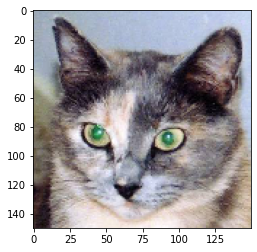

In [33]:
plt.imshow(img_tensor[0])
plt.show()

확인하고 싶은 특성 맵을 추출하기 위해 이미지 배치를 입력으로 받아 모든 합성곱과 풀링 층의 활성화를 출력하는 케라스 모델을 만들 것입니다. 이를 위해 케라스의 `Model` 클래스를 사용하겠습니다. 모델 인스턴스를 만들 때 두 개의 매개변수가 필요합니다. 입력 텐서(또는 입력 텐서의 리스트)와 출력 텐서(또는 출력 텐서의 리스트)입니다. 반환되는 객체는 `Sequential`과 같은 케라스 모델이지만 특정 입력과 특정 출력을 매핑합니다. `Model` 클래스를 사용하면 `Sequential`과는 달리 여러 개의 출력을 가진 모델을 만들 수 있습니다. `Model` 클래스에 대해 더 자세한 내용은 7.1절을 참고하세요.

In [34]:
from keras import models

# 상위 8개 층의 출력을 추출합니다:
layer_outputs = [layer.output for layer in model.layers[:8]]
# 입력에 대해 8개 층의 출력을 반환하는 모델을 만듭니다:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

입력 이미지가 주입될 때 이 모델은 원본 모델의 활성화 값을 반환합니다. 이 모델이 이 책에서는 처음 나오는 다중 출력 모델입니다. 지금까지 본 모델은 정확히 하나의 입력과 하나의 출력만을 가졌습니다. 일반적으로 모델은 몇 개의 입력과 출력이라도 가질 수 있습니다. 이 모델은 하나의 입력과 층의 활성화마다 하나씩 총 8개의 출력을 가집니다.

In [35]:
# 층의 활성화마다 하나씩 8개의 넘파이 배열로 이루어진 리스트를 반환합니다:
activations = activation_model.predict(img_tensor)

예를 들어 다음이 고양이 이미지에 대한 첫 번째 합성곱 층의 활성화 값입니다:

In [36]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


32개의 채널을 가진 148 × 148 크기의 특성 맵입니다. 원본 모델의 첫 번째 층의 활성화 중에서 스무 번째 채널을 그려 보겠습니다:

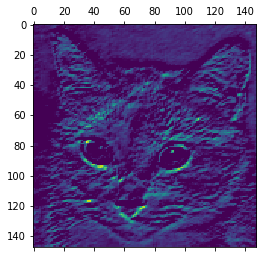

In [37]:
plt.matshow(first_layer_activation[0, :, :, 20], cmap='viridis')
plt.show()

이 채널은 대각선 에지를 감지하도록 인코딩된 것 같습니다. 열여섯 번째 채널을 그려보죠. 합성곱 층이 학습한 필터는 결정적이지 않기 때문에 채널 이미지가 각자 다를 수 있습니다.

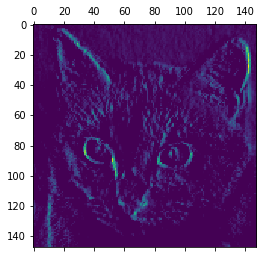

In [38]:
plt.matshow(first_layer_activation[0, :, :, 15], cmap='viridis')
plt.show()

이 채널은 '밝은 녹색 점'을 감지하는 것 같아 고양이 눈을 인코딩하기 좋습니다. 이제 네트워크의 모든 활성화를 시각화해 보겠습니다. 8개의 활성화 맵에서 추출한 모든 채널을 그리기 위해 하나의 큰 이미지 텐서에 추출한 결과를 나란히 쌓겠습니다.

In [39]:
# 층의 이름을 그래프 제목으로 사용합니다
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# 특성 맵을 그립니다
for layer_name, layer_activation in zip(layer_names, activations):
    # 특성 맵에 있는 특성의 수
    n_features = layer_activation.shape[-1]

    # 특성 맵의 크기는 (1, size, size, n_features)입니다
    size = layer_activation.shape[1]

    # 활성화 채널을 위한 그리드 크기를 구합니다
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # 각 활성화를 하나의 큰 그리드에 채웁니다
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # 그래프로 나타내기 좋게 특성을 처리합니다
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # 그리드를 출력합니다
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

Output hidden; open in https://colab.research.google.com to view.

몇 가지 주목할 내용이 있습니다:

* 첫 번째 층은 여러 종류의 에지 감지기를 모아 놓은 것 같습니다. 이 단계의 활성화에는 초기 사진에 있는 거의 모든 정보가 유지됩니다.
* 상위 층으로 갈수록 활성화는 점점 더 추상적으로 되고 시각적으로 이해하기 어려워집니다. '고양이 귀'와 '고양이 눈'과 같이 고수준의 개념을 인코딩하기 시작합니다. 상위 층의 표현은 이미지의 시각적 콘텐츠에 관한 정보가 점점 줄어들고 이미지의 클래스에 관한 정보가 점점 증가합니다.
* 비어 있는 활성화가 층이 깊어짐에 따라 늘어납니다. 첫 번째 층에서는 모든 필터가 입력 이미지에 활성화되었지만 층을 올라가면서 활성화되지 않는 필터들이 생깁니다. 필터에 인코딩된 패턴이 입력 이미지에 나타나지 않았다는 것을 의미입니다.

심층 신경망이 학습한 표현에서 일반적으로 나타나는 중요한 특징을 조금 전 확인했습니다. 층에서 추출한 특성은 층의 깊이를 따라 점점 더 추상적이 됩니다. 높은 층의 활성화는 특정 입력에 관한 시각적 정보가 점점 줄어들고 타깃에 관한 정보(이 경우에는 강아지 또는 고양이 이미지의 클래스)가 점점 더 증가합니다. 심층 신경망은 입력되는 원본 데이터(여기서는 RGB 포맷의 사진)에 대한 정보 정제 파이프라인처럼 작동합니다. 반복적인 변환을 통해 관계없는 정보(예를 들어 이미지에 있는 특정 요소)를 걸러내고 유용한 정보는 강조되고 개선됩니다(여기에서는 이미지의 클래스).

사람과 동물이 세상을 인지하는 방식이 이와 비슷합니다. 사람은 몇 초동안 한 장면을 보고 난 후에 그 안에 있었던 추상적인 물체(자전거, 나무)를 기억할 수 있습니다. 하지만 이 물체의 구체적인 모양을 기억하지 못합니다. 사실 기억을 더듬어 일반적인 자전거를 그려보면 평생 수천 개의 자전거를 보았더라도 조금이라도 비슷하게 그릴 수 없습니다. 실제로 한 번 해보면 진짜 그런지 알 수 있습니다. 우리의 뇌는 시각적 입력에서 관련성이 적은 요소를 필터링하여 고수준의 개념으로 변환합니다. 이렇게 완전히 추상적으로 학습하기 때문에 눈으로 본 것을 자세히 기억하기는 매우 어렵습니다.

## 컨브넷 필터 시각화

컨브넷이 학습한 필터를 조사하는 또 다른 간편한 방법은 각 필터가 반응하는 시각적 패턴을 그려보는 것입니다. 빈 입력 이미지에서 시작해서 특정 필터의 응답을 최대화하기 위해 컨브넷 입력 이미지에 경사 상승법을 적용합니다. 결과적으로 입력 이미지는 선택된 필터가 최대로 응답하는 이미지가 될 것입니다.

전체 과정은 간단합니다. 특정 합성곱 층의 한 필터의 값을 최대화하는 손실 함수를 정의합니다. 이 활성화 값을 최대화하기 위해 입력 이미지를 변경하도록 확률적 경사 상승법을 사용합니다. 예를 들어 여기에서는 ImageNet에 사전 훈련된 VGG16 네트워크에서 `block3_conv1` 층의 필터 0번의 활성화를 손실로 정의합니다:

## setup

In [40]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Setup


In [41]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# The dimensions of our input image
img_width = 180
img_height = 180
# Our target layer: we will visualize the filters from this layer.
# See `model.summary()` for list of layer names, if you want to change this.
layer_name = "conv3_block4_out"


## Build a feature extraction model


In [42]:
# Build a ResNet50V2 model loaded with pre-trained ImageNet weights
model = keras.applications.ResNet50V2(weights="imagenet", include_top=False)

# Set up a model that returns the activation values for our target layer
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)


94674944/94668760 [==============================] - 1s 0us/step


## Set up the gradient ascent process

The "loss" we will maximize is simply the mean of the activation of a specific filter in
our target layer. To avoid border effects, we exclude border pixels.


In [43]:

def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)



Our gradient ascent function simply computes the gradients of the loss above
with regard to the input image, and update the update image so as to move it
towards a state that will activate the target filter more strongly.


In [44]:

@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img



## Set up the end-to-end filter visualization loop

Our process is as follow:

- Start from a random image that is close to "all gray" (i.e. visually netural)
- Repeatedly apply the gradient ascent step function defined above
- Convert the resulting input image back to a displayable form, by normalizing it,
center-cropping it, and restricting it to the [0, 255] range.


In [45]:

def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 3))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img



Let's try it out with filter 0 in the target layer:


In [46]:
from IPython.display import Image, display

loss, img = visualize_filter(0)
keras.preprocessing.image.save_img("0.png", img)


This is what an input that maximizes the response of filter 0 in the target layer would
look like:


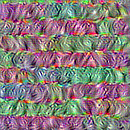

In [47]:
display(Image("0.png"))


## Visualize the first 64 filters in the target layer

Now, let's make a 8x8 grid of the first 64 filters
in the target layer to get of feel for the range
of different visual patterns that the model has learned.


In [48]:
# Compute image inputs that maximize per-filter activations
# for the first 64 filters of our target layer
all_imgs = []
for filter_index in range(64):
    print("Processing filter %d" % (filter_index,))
    loss, img = visualize_filter(filter_index)
    all_imgs.append(img)

# Build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# Fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img = all_imgs[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = img
keras.preprocessing.image.save_img("stiched_filters.png", stitched_filters)

from IPython.display import Image, display

display(Image("stiched_filters.png"))


Output hidden; open in https://colab.research.google.com to view.

In [49]:
# 파라미터 설정
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]

# The local path to our target image
img_path = keras.utils.get_file(
    "african_elephant.jpg", " https://i.imgur.com/Bvro0YD.png"
)

display(Image(img_path))


Output hidden; open in https://colab.research.google.com to view.

## The Grad-CAM algorithm


In [50]:

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap



## Let's test-drive it


Predicted: [('n02504458', 'African_elephant', 0.8871446)]


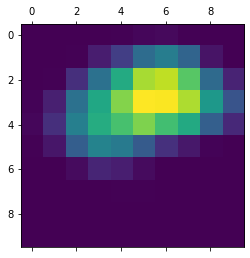

In [51]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()



## Create a superimposed visualization

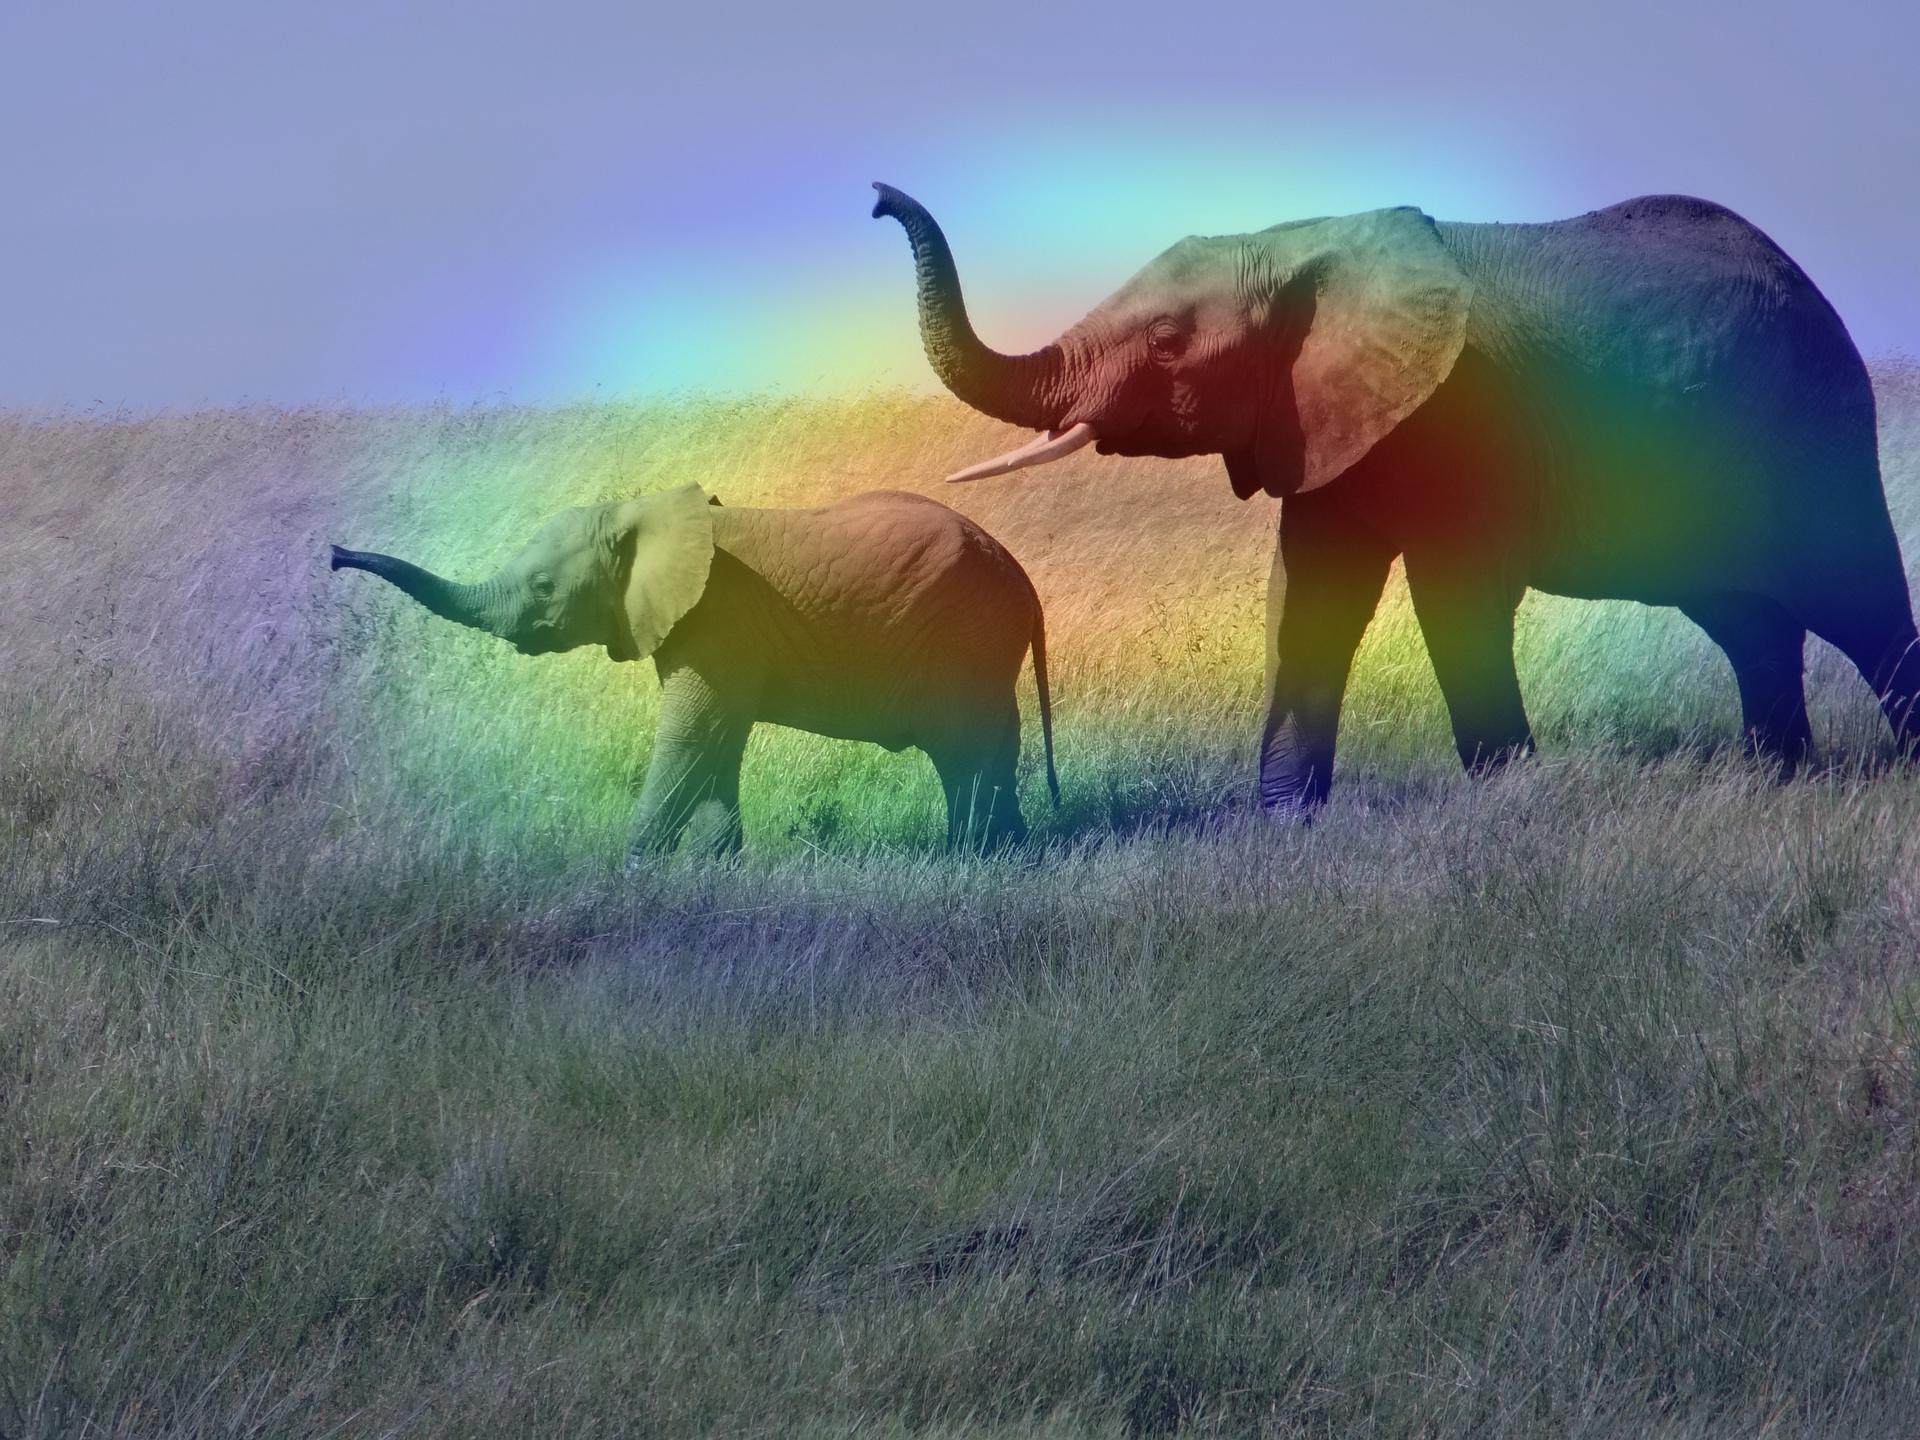

In [52]:
# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))
